# Variational Autoencoder (VAE)

Useful links: 
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In this homework we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset (LFW) (http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)


## Prepare the data

In [1]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import fetch_lfw_dataset
data, attrs = fetch_lfw_dataset()

In [3]:
X_train = data[:10000].reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:].reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 6075)
(3143, 6075)


For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [4]:
X_train = np.float32(X_train)
X_train = X_train/255
X_val = np.float32(X_val)
X_val = X_val/255

In [5]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

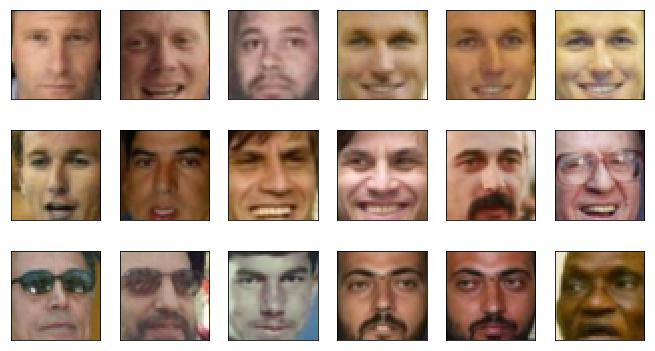

In [6]:
plot_gallery(X_train, image_h, image_w)

In [7]:
train = data_utils.TensorDataset(torch.Tensor(X_train), torch.zeros(X_train.shape[0],)) # pseudo labels needed to define TensorDataset
train_loader = data_utils.DataLoader(train, batch_size=100, shuffle=True)

val = data_utils.TensorDataset(torch.Tensor(X_val), torch.zeros(X_val.shape[0],))
val_loader = data_utils.DataLoader(val, batch_size=1, shuffle=False)

# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

<img src="Autoencoder_structure.png" alt="Autoencoder">

In [16]:
class Flatten(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()
        
    def forward(self, x):
        return x.view(x.size(0), -1)
    
class ToImage(nn.Module):
    def __init__(self, H=image_h, W=image_w, C=3):
        super(self.__class__, self).__init__()
        self.h = H
        self.w = W
        self.c = C
        
    def forward(self, x):
        return x.reshape(self.h, self.w, self.c)

In [23]:
dimZ = 32 # Considering face reconstruction task, which size of representation seems reasonable?

# Define the decoder and encoder as networks with one hidden fc-layer
# (that means you will have 2 fc layers in each net)
# Use ReLU for hidden layers' activations
# GlorotUniform initialization for W
# Zero initialization for biases
# It's also convenient to put sigmoid activation on output layer to get nice normalized pics

class Autoencoder(nn.Module):
    def __init__(self, code_size=32):
        super(Autoencoder, self).__init__()
        
        #TODO
        h1_units = int(code_size*6)
        h2_units = int(code_size*4)
        h3_units = int(code_size*2)
        
        self.encoder = nn.Sequential(
            #Flatten(),
            nn.Linear(image_h*image_w*3, h1_units),
            #nn.BatchNorm1d(h1_units),
            nn.ELU(),
            
            nn.Linear(h1_units, h2_units),
            #nn.BatchNorm1d(h2_units),
            nn.ELU(),
            
            nn.Linear(h2_units, h3_units),
            #nn.BatchNorm1d(h3_units),
            nn.ELU(),
            
            nn.Linear(h3_units, code_size)
        )
        self.decoder = nn.Sequential(
            nn.Linear(code_size, h3_units),
            #nn.BatchNorm1d(h3_units),
            nn.ELU(),
            
            
            nn.Linear(h3_units, h2_units),
            #nn.BatchNorm1d(h2_units),
            nn.ELU(),
            
            nn.Linear(h2_units, h1_units),
            #nn.BatchNorm1d(h1_units),
            nn.ELU(),
    
            nn.Linear(h1_units, image_h*image_w*3),
            nn.Sigmoid(),
            #ToImage()
        )
        
    def forward(self, x):
        #TODO
        
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        
        return reconstruction, latent_code

In [24]:
use_cuda = True
device = torch.device('gpu:0' if torch.cuda.is_available() and use_cuda else 'cpu')
device.type

'cpu'

In [35]:
# Create MSE loss function
criterion = torch.nn.MSELoss()
# L1 loss gives slightly better results cause images are in range (0, 1) so this loss more strict
#criterion = torch.nn.L1Loss()

autoencoder = Autoencoder().to(device)

# Use Adam optimizer
optimizer = optim.Adam(autoencoder.parameters())

In [36]:
from IPython.display import clear_output

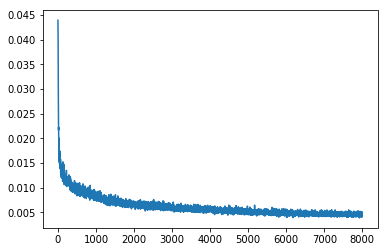

Epoch 79. MSE loss train: 0.4539017197676003


In [37]:
# Train your autoencoder
# Visualize progress in reconstruction and loss decay
autoencoder.train()

epochs = 80
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    autoencoder.train(True)
    train_agg_loss = 0
    for x_batch, _ in train_loader:
        inp = Variable(x_batch).to(device)
        pred, _ = autoencoder(inp)
        loss = criterion(pred, x_batch.to(device))
        train_agg_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss_list.append(loss.item())
    
    # Visualise loss
    clear_output()
    plt.plot(train_loss_list)
    plt.show()
    
    print(f"Epoch {epoch}. MSE loss train: {train_agg_loss}")

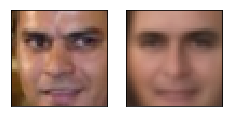

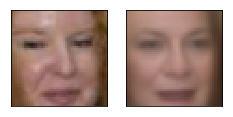

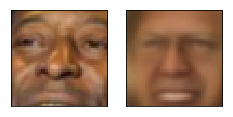

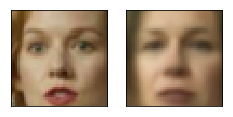

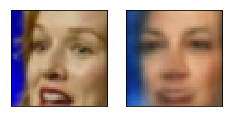

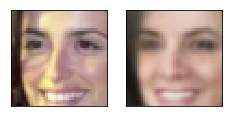

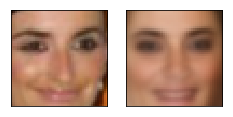

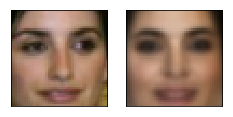

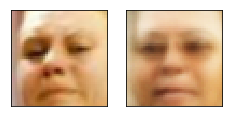

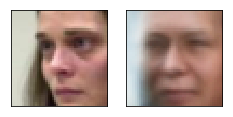

In [38]:
# Examine the reconstructions
autoencoder.train(False)
for j, data in enumerate(val_loader, 0):
    inp = Variable(data[0].to(device))
    pred, _ = autoencoder(inp)
    plot_gallery([data[0].numpy(), pred.data.cpu().numpy()], image_h, image_w, n_row=1, n_col=2)
    if (j >= 9):
        break

Reconstruction is not bad, right? 

# Sampling

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

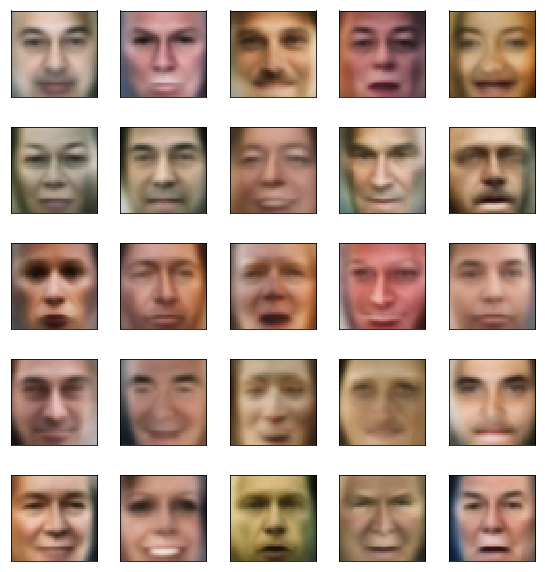

In [34]:
# MAE loss results
z = np.random.randn(25, dimZ)*0.5
output = autoencoder.decoder(Variable(torch.from_numpy(z).type(torch.FloatTensor).to(device)))
plot_gallery(output.data.cpu().numpy(), image_h, image_w, n_row=5, n_col=5)

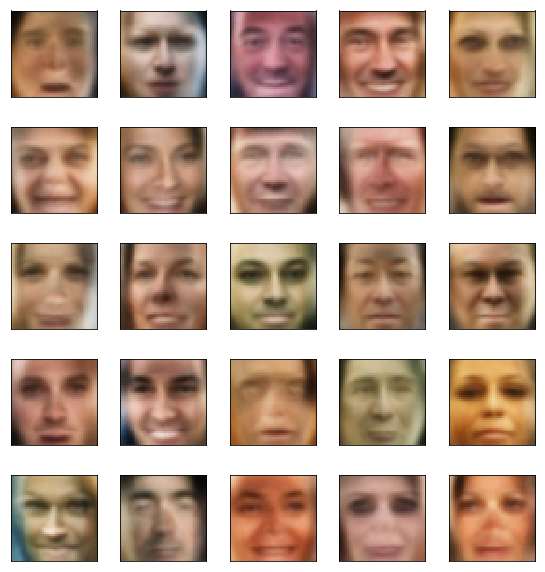

In [39]:
# MSE loss results
z = np.random.randn(25, dimZ)*0.5
output = autoencoder.decoder(Variable(torch.from_numpy(z).type(torch.FloatTensor).to(device)))
plot_gallery(output.data.cpu().numpy(), image_h, image_w, n_row=5, n_col=5)

So, if we sample $z$ from normal, whould we eventually generate all possible faces? What do you think?

# Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler** layer, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [77]:
# to compare with conventional AE, keep these hyperparameters
# or change them for the values that you used before
dimZ = 32

# define the network
# you can start from https://github.com/pytorch/examples/blob/master/vae/main.py
# or Theano-based examples here https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST

class VAE(nn.Module):
    def __init__(self, code_size=32):
        super(VAE, self).__init__()
        
        #TODO
        h1_units = int(code_size*6)
        h2_units = int(code_size*4)
        h3_units = int(code_size*2)
        
        self.encoder = nn.Sequential(
            nn.Linear(image_h*image_w*3, h1_units),
            #nn.BatchNorm1d(h1_units),
            nn.ELU(),
            
            nn.Linear(h1_units, h2_units),
            #nn.BatchNorm1d(h2_units),
            nn.ELU(),
            
            nn.Linear(h2_units, h3_units),
            #nn.BatchNorm1d(h3_units),
            nn.ELU()
        )
        
        self.logsigma_head = nn.Linear(h3_units, code_size)
        self.mu_head = nn.Linear(h3_units, code_size)
        
        self.decoder = nn.Sequential(
            nn.Linear(code_size, h3_units),
            #nn.BatchNorm1d(h3_units),
            nn.ELU(),
            
            
            nn.Linear(h3_units, h2_units),
            #nn.BatchNorm1d(h2_units),
            nn.ELU(),
            
            nn.Linear(h2_units, h1_units),
            #nn.BatchNorm1d(h1_units),
            nn.ELU(),
    
            #nn.Linear(h1_units, image_h*image_w*3),
            #nn.Sigmoid(),
            #ToImage()
        )
        
        self.reconstruction_logsigma_head = nn.Linear(h1_units, image_h*image_w*3)
        self.reconstruction_mu_head = nn.Linear(h1_units, image_h*image_w*3)
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(logsigma)
            eps = torch.rand_like(std)#Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        
        #TODO
        code = self.encoder(x)
        latent_mu = self.mu_head(code)
        latent_logsigma = self.logsigma_head(code)
        
        sample = self.gaussian_sampler(latent_mu, latent_logsigma)
        
        reconstruction = self.decoder(sample)
        reconstruction_mu = self.reconstruction_mu_head(reconstruction)
        reconstruction_logsigma = self.reconstruction_logsigma_head(reconstruction)
        
        return reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p_{\theta}(z)) + \log p_{\theta}(x|z)$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_I-x)^2}{2\sigma_i^2}} \Big)=...$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$?

In [84]:
def KL_divergence(mu, logsigma):
    return - 0.5 * (1 + 2*logsigma - mu**2 - logsigma.exp_() ** 2).sum()

def log_likelihood(x, mu, logsigma):
    return (- logsigma - (0.5*(mu - x)**2) / (logsigma.exp_() ** 2 + 1.e-8)).sum()

def loss_vae(x, mu_gen, logsigma_gen, mu_z, logsigma_z):
    kl_term = KL_divergence(mu_z, logsigma_z)
    data_term = log_likelihood(x, mu_gen, logsigma_gen)
    return data_term - kl_term

And train the model:

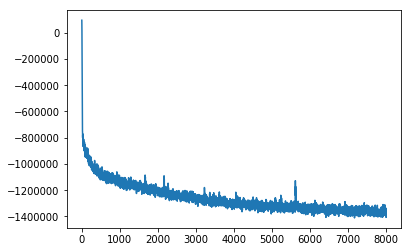

Epoch 79. MSE loss train: -136307067.25


In [85]:
# train your autoencoder
# visualize progress in reconstruction and loss decay
# Train your autoencoder
# Visualize progress in reconstruction and loss decay
vae = VAE().to(device)

# Use Adam optimizer
optimizer = optim.Adam(vae.parameters())

epochs = 80
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    vae.train(True)
    train_agg_loss = 0
    for x_batch, _ in train_loader:
        inp = Variable(x_batch).to(device)
        result = vae(inp)
        loss = -loss_vae(inp, *result)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_agg_loss += loss.item()
        train_loss_list.append(loss.item())
    
    # Visualise loss
    clear_output()
    plt.plot(train_loss_list)
    plt.show()
    
    print(f"Epoch {epoch}. MSE loss train: {train_agg_loss}")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


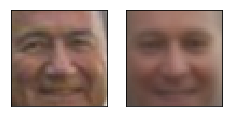

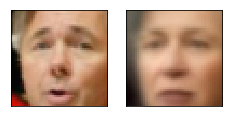

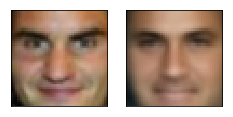

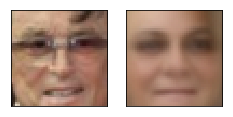

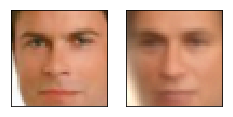

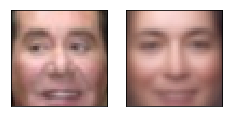

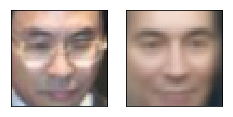

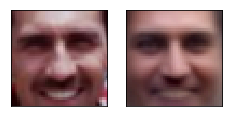

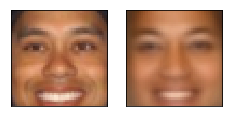

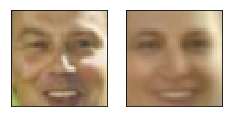

In [87]:
val_loader = data_utils.DataLoader(val, batch_size=1, shuffle=True)
vae.eval()
for j, data in enumerate(val_loader, 0):
    input = Variable(data[0]).to(device)
    reconstruction_mu, _, _, _ = vae(input)
    plot_gallery([data[0].numpy(), reconstruction_mu.data.cpu().numpy()], image_h, image_w, n_row=1, n_col=2)
    if (j >= 9):
        break

And finally sample from VAE.

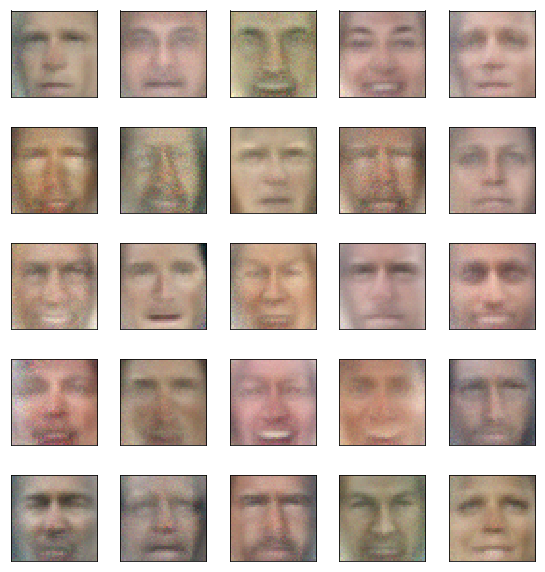

In [105]:
# TODO
# Sample some images from the learned distribution
# 1) Sample z ~ N(0,1)
# 2) Sample from N(decoder_mu(z), decoder_sigma(z))
z = np.random.randn(25, dimZ)*0.5
output = vae.decoder(Variable(torch.from_numpy(z).type(torch.FloatTensor).to(device)))

reconstruction_mu = vae.reconstruction_mu_head(output)
reconstruction_logsigma = vae.reconstruction_logsigma_head(output)

z = torch.rand_like(reconstruction_logsigma)
output = reconstruction_mu + z * torch.exp(reconstruction_logsigma)
max_out = output.max()
min_out = output.min()
output = (output - min_out) / (max_out - min_out)

plot_gallery(output.data.cpu().numpy(), image_h, image_w, n_row=5, n_col=5)

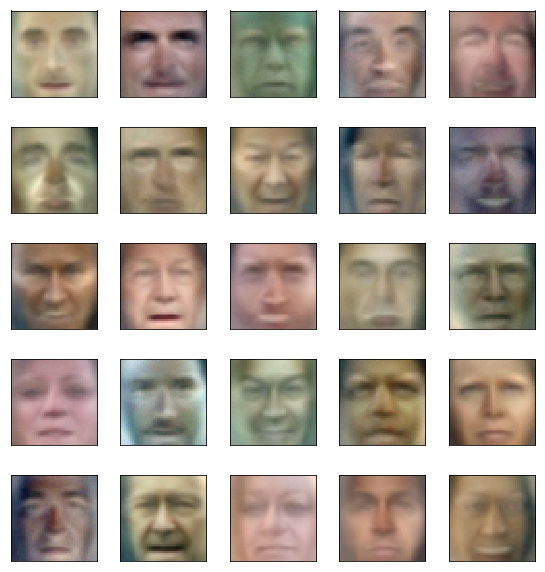

In [107]:
# Only mean
z = np.random.randn(25, dimZ)
output = vae.decoder(Variable(torch.from_numpy(z).type(torch.FloatTensor).to(device)))

reconstruction_mu = vae.reconstruction_mu_head(output)

output = reconstruction_mu
max_out = output.max()
min_out = output.min()
output = (output - min_out) / (max_out - min_out)

plot_gallery(output.data.cpu().numpy(), image_h, image_w, n_row=5, n_col=5)

Even if in practice you do not see the much difference between AE and VAE, or VAE is even worse, the little bayesian inside you should be jumping for joy right now. 

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it. 

# Congrats! and Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column, but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE. 

<img src="linear.png" alt="linear">